# **Feature Engineering by pycaret**

pycaretによるdiamondsデータセットの回帰実行サンプル  
特徴量エンジニアリング機能を使ってみる

参考にしたURL  
【公式】 Regression  
https://pycaret.readthedocs.io/en/latest/api/regression.html  

Setting up Environment  
https://pycaret.org/setup/  

pycaret/examples/  
https://github.com/pycaret/pycaret/tree/master/examples  

## **事前準備**

#### **Google Colaboratoyの環境確認/設定**

In [1]:
# Linuxの環境確認
!cat /etc/issue   # OSバージョン
!uname -a         # 〃
!cat /proc/cpuinfo | grep 'model name'                                   # CPU
!cat /proc/meminfo | grep Mem | awk '{print $1 " " $2/1024/1024 " GB"}'  # メモリ
!df -h | grep -v -e tmp -e shm                                           # ファイルシステム
!cat /proc/uptime  | awk '{print $1/60/60 " hours (" $1 "sec)"}'         # uptime
!nvidia-smi                                                              # GPU

# pycaret関連のインストール
! pip uninstall -y lightgbm 
! pip install -U lightgbm --install-option=--gpu
! pip install -U pycaret[full]

Ubuntu 18.04.5 LTS \n \l

Linux fbaee1d14e18 5.4.104+ #1 SMP Sat Jun 5 09:50:34 PDT 2021 x86_64 x86_64 x86_64 GNU/Linux
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
MemTotal: 25.4597 GB
MemFree: 22.6045 GB
MemAvailable: 24.5395 GB
Filesystem      Size  Used Avail Use% Mounted on
overlay         148G   38G  110G  26% /
/dev/sda1       154G   41G  114G  27% /opt/bin/.nvidia
0.0457722 hours (164.78sec)
Sat Aug 28 16:37:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               | 

### **ライブラリの読み込み**

In [2]:
import sys
print(sys.version)   # pythonバージョン: 3.7.11 (default, Jul  3 2021, 18:01:19) 
import math
import random
import copy
import os
import statistics as stat
from pprint   import pprint
from datetime import datetime, timedelta, timezone
JST = timezone(timedelta(hours=+9), 'JST')
print(f'now: {datetime.now(JST):"%F %T)}') 

import numpy  as np
import pandas as pd
# pandas表示設定値の変更
pd.set_option('display.width',      100)
pd.set_option('display.precision',    4)
pd.set_option('display.max_rows',    20)
pd.set_option('display.max_columns', 12)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics

import sklearn 
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
# metrics for Classificaqtion
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# metrics for  regression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import pycaret
from pycaret.regression import * ####  regressionモジュールをインポート

import xgboost
import lightgbm
import catboost
import optuna


#バージョン確認
print(f'Module\'s Version; ',
      f'pycaret: {pycaret.__version__}, sklearn: {sklearn.__version__},',
      f'xgboost: {xgboost.__version__}, lightgbm: {lightgbm.__version__},',
      f'catboost: {catboost.__version__}, optuna: {optuna.__version__}'
      )

3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]
now: "2021-08-29 01:41:12)
Module's Version;  pycaret: 2.3.3, sklearn: 0.23.2, xgboost: 1.4.2, lightgbm: 3.2.1, catboost: 0.26.1, optuna: 2.9.1


#### **関数定義**

In [3]:
### Functions =================================================================
# pandas.describeメソッドの拡張
def xdescribe(df, dsp=True, ret=False):    

    print(f'## Shape: {df.shape}')
    dtype    = pd.DataFrame({'dtype' : df.dtypes        })
    n_na     = pd.DataFrame({'NAs'   : df.isnull().sum()})
    n_unique = pd.DataFrame({'n_unique': [len(df[c].unique()) for c in df.columns]},
                            index=df.columns)
    df_descr = df.describe(include='all').T
    if 'unique' in df_descr.columns:
        df_descr = df_descr.drop(['unique'], axis=1)
    df_descr = pd.concat([dtype, n_na, n_unique, df_descr], axis=1)
    df_descr['count'] = df_descr['count'].astype(int)

    if dsp:
        # backup & restore pandas display sttting
        mr = pd.get_option('display.max_rows')  # backup sttting
        pd.set_option('display.max_rows', None) # unlimitted
        display(df_descr)
        pd.set_option('display.max_rows', mr)   # restore sttting

        # Category Features: Print Elements
        prt = True
        for idx in df_descr.index:
            if df_descr['dtype'].astype(str)[idx] == 'category':
                if prt:
                    print(f'### Featur: Categories')
                    prt = False 
                print(f' {idx}: \t{df[idx].cat.categories}')

    if ret:
        return df_descr
    else:
        return

### Functions =================================================================
# 目的変数の分布を確認
def target_dist(df, target_colname):
    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(df[target_colname])
    skewness    = skew(df[target_colname].dropna())
    print( f'\n 平均 = {mu:.2f}, 分散 = {sigma:.2f}, 歪度 = {skewness:.2f}')

    # plot the distribution
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title(target_colname+' distribution')
    sns.distplot(df[target_colname], fit=norm)

    ax = fig.add_subplot(1, 2, 2)
    stats.probplot(df[target_colname], plot=plt) #Q-Q plot
    plt.show()

### Functions =================================================================
# カテゴリ変数の分布を確認
def plt_box_dist(df, target, feature):
    n_unique = len(df[feature].unique())
    font_size = 12 - n_unique / 5
    fig_height = 1 + n_unique / 4
    fig = plt.figure(figsize=(8,fig_height))

    # boxplot
    ax0 = plt.subplot2grid((1, 6), (0, 0), colspan=4)
    sns.boxplot(y=df[feature], x=df[target], color='#628CD2', width=0.7, 
                flierprops={'markersize':3,'markerfacecolor':'gray','markeredgecolor':'None','alpha':0.2})
    ax0.set_yticklabels(ax0.get_yticklabels(), size=font_size)

    # distribution
    ax1 = plt.subplot2grid((1, 6), (0, 4), colspan=2)
    sns.countplot(y=df[feature], color='#628CD2')
    ax1.set_yticklabels([])
    ax1.set_ylabel('')
    plt.show()

### Functions =================================================================
# 数値変数の分布を確認
def plt_reg_dist(df, target, feature):
    n_unique = len(df[feature].unique())
    font_size = 10
    fig_height = 3
    fig = plt.figure(figsize=(8,fig_height))

    # regplot
    ax0 = plt.subplot2grid((1, 6), (0, 0), colspan=4)
    sns.regplot(data=df, x=target, y=feature, color='#3050A0',
                scatter_kws={'alpha':0.15, 's':12}, line_kws={'lw':1, 'color':'black'})

    # distribution
    ax1 = plt.subplot2grid((1, 6), (0, 4), colspan=2)
    sns.histplot(data=df, y=feature, stat='count', bins=30, color='#628CD2', shrink=1.0, kde=True)
    ax1.set_yticklabels([])
    ax1.set_ylabel('')
    plt.show()

### **データの取得・確認**

#### **seabornに含まれているdiamondsデータセットを使用**

各変数の属性の確認  
目的変数の分布を確認


## Shape: (53940, 10)
## Shape: (53940, 10)


,dtype,NAs,n_unique,count,top,freq,mean,std,min,25%,50%,75%,max
carat,float64,0,273,53940,NaN,NaN,0.7979,0.474,0.2,0.4,0.7,1.04,5.01
cut,category,0,5,53940,Ideal,21551,NaN,NaN,NaN,NaN,NaN,NaN,NaN
color,category,0,7,53940,G,11292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
clarity,category,0,8,53940,SI1,13065,NaN,NaN,NaN,NaN,NaN,NaN,NaN
depth,float64,0,184,53940,NaN,NaN,61.75,1.433,43,61,61.8,62.5,79
table,float64,0,127,53940,NaN,NaN,57.46,2.234,43,56,57,59,95
price,int64,0,11602,53940,NaN,NaN,3933,3989,326,950,2401,5324,1.882e+04
x,float64,0,554,53940,NaN,NaN,5.731,1.122,0,4.71,5.7,6.54,10.74
y,float64,0,552,53940,NaN,NaN,5.735,1.142,0,4.72,5.71,6.54,58.9
z,float64,0,375,53940,NaN,NaN,3.539,0.7057,0,2.91,3.53,4.04,31.8


### Featur: Categories
 cut: 	Index(['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'], dtype='object')
 color: 	Index(['D', 'E', 'F', 'G', 'H', 'I', 'J'], dtype='object')
 clarity: 	Index(['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1'], dtype='object')
Shapes: train:(43152, 10), test:(10788, 10)

## 目的変数の分布を確認

 平均 = 3933.70, 分散 = 3991.40, 歪度 = 1.62


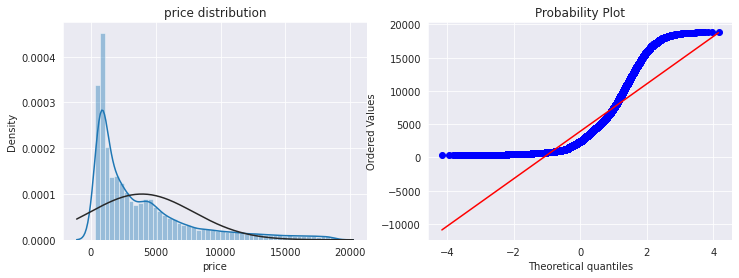


## 説明変数の分布を確認

## 0/9, carat


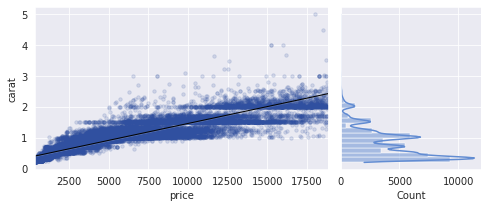


## 1/9, cut


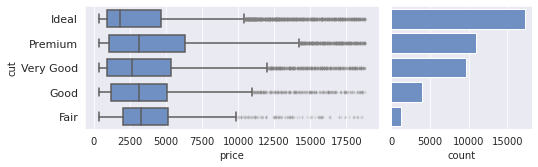


## 2/9, color


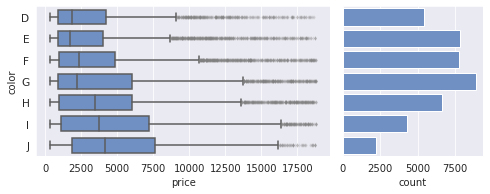


## 3/9, clarity


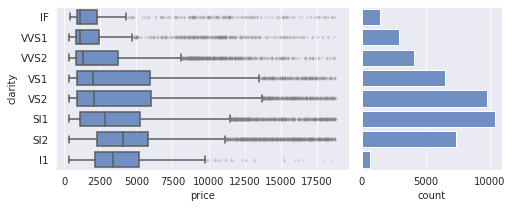


## 4/9, depth


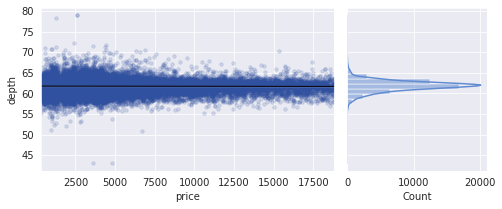


## 5/9, table


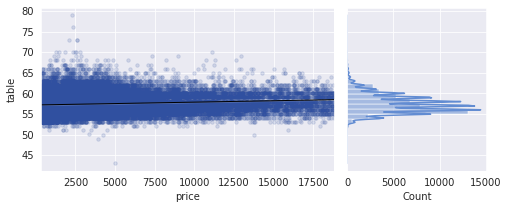


## 6/9, x


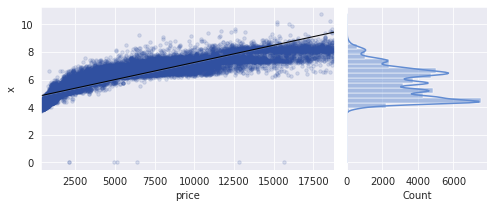


## 7/9, y


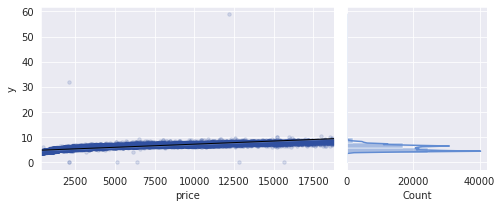


## 8/9, z


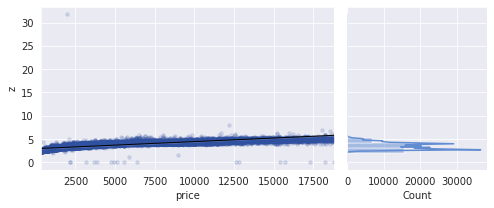

In [5]:
# diamondsデータセットの読み込み
df = sns.load_dataset('diamonds') 
#   carat: weight of the diamond (0.2--5.01)
#     cut: cut qualitiy, Fair, Good, Very Good, Premium, Ideal
#   color: diamond colour, D (best) ~ J (worst)
# clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
#   depth: depth % :total depth percentage = z / mean(x, y) = 2 * z / (x + y)
#   table: table%: width of top of diamond relative to widest point
#   price: price in US dollars (\$326--\$18,823)
# x, y, z: length, width and depth in mm
print(f'## Shape: {df.shape}')

df_xdesc = xdescribe(df, ret=True) # 各変数の属性を表示

target_colname = 'price'          # 目的変数を指定
target_metric  = 'R2'             # 評価項目を指定
target_metric_ascending = False   # 評価項目のソート順

# データセットの分割 (学習用と学習結果の評価用)
df_train, df_test = train_test_split(df, train_size=0.8, random_state=0, shuffle=True)
print(f'Shapes: train:{df_train.shape}, test:{df_test.shape}')

print(f'\n## 目的変数の分布を確認') 
target_dist(df_train, target_colname)

print(f'\n## 説明変数の分布を確認')
feature_colnames = [c for c in df_train.columns if c !=target_colname]
for i, colname in enumerate(feature_colnames):
    print(f'\n## {i}/{len(feature_colnames)}, {colname}')
    if str(df_xdesc.loc[colname, 'dtype']) in ['object', 'category'] \
       or df_xdesc.loc[colname, 'n_unique'] <= 30:
        plt_box_dist(df_train, target_colname, colname)
    else:
        plt_reg_dist(df_train, target_colname, colname)


## モデルの準備

# 対象モデルの設定
estimators = ['catboost','lightgbm','xgboost','rf','gbr','et','ada','dt','lr','ridge','lasso','en']
# 結果集約用データフレームの作成
model_scores = pd.DataFrame(columns=['Desc','Model','MAE','MSE','RMSE','R2','RMSLE','MAPE','Elapse(Min)']) 

## **特徴量前処理パターン 1 (ほぼデフォルト)**

### **データセット、学習に関する設定 (setup)**

参考にしたURL  
PyCaretのsetup関数の引数について  
https://qiita.com/Asagumo63/items/99357d4b472a9219040e  
PyCaretでできる前処理について調べてみた  
https://qiita.com/tomiyou/items/e1842775e7aaee04ada3


In [6]:
exp1 = setup(
    # データセット関連
    df_train,                     # 学習対象のデータセット
    target = target_colname,      # 目的変数名
    categorical_features = None,  # カテゴリ変数名のリスト        (list of str, default=None)
    ordinal_features     = None,  # 順序変数名と順序リストの辞書  ({col:[lv1,lv2,..]}:low <...< High)
    numeric_features     = None,  # 数値変数の列名のリスト        (list of str, default=None)
    date_features        = None,  # 日付変数の列名のリスト        (list of str, default=None)
    ignore_features      = None,  # 学習に使用しない列名

    # 特徴量エンジニアリング関連
    high_cardinality_features   = None,   # カテゴリ量が多い列名のリスト (list of str, default=None)
    high_cardinality_method     = 'frequency', # メッソド(frequency, clustering) (str, default='frequency')
    normalize                   = False, # 正規化                    (bool, default = False)
    normalize_method            = 'zscore', # 正規化メッソド(zscore,minmax,robust) (str, default='zscore')
    transformation              = False, # 説明変数の対数変換         (bool, default = False)
    transformation_method       = 'yeo-johnson', # 説明変数の対数変換メソッド (str, default='yeo-johnson')
    pca                         = False, # pcaによる次元削減          (bool, default=False)
    pca_method                  = 'linear', # pcaのメッソド(linear, kernel, incremental) (str, default='linear')
    pca_components              = None,  # 保持する特徴の数or特徴の割合 (int or float, default=None)
    ignore_low_variance         = False, # 低分散の特徴量を削除       (bool, default=False)
    combine_rare_levels         = False, # 低頻度カテゴリ値の合成     (bool, default=False)
    rare_level_threshold        = 0.1,   # 結合する低頻度カテゴリの割合(float, default = 0.1)
    bin_numeric_features        = None,  # bin化する数値変数名のリスト(list of str, default=None)
    remove_outliers             = False, # 外れ値削除                 (bool,  default=False)
    outliers_threshold          = 0.05,  # 外れ値削除の閾値           (float, default=0.05)
    remove_multicollinearity    = False, # 共線性の高い列の削除       (bool,  default=False)
    multicollinearity_threshold = 0.9,   # 共線性の高い列の削除の閾値 (float, default=0.9)
    create_clusters             = False, # クラスタによる特徴量の追加 (bool,  default=False)
    cluster_iter                = 20,    # 追加する特徴量のクラスタ数 (int, default = 20)
    feature_selection           = False, # 特徴量選択                 (bool,  default=False)
    feature_selection_threshold = 0.8,   # 特徴量選択の閾値           (float, default=0.8)
    transform_target            = False, # 目的変数の対数変換         (bool,  default=False)
    transform_target_method     = 'box-cox', # 目的変数の変換方式(box-cox, yeo-johnson) (str, default='box-cox')

    # 学習環境関連
    train_size = 0.8,         # 学習で使うデータの割合。残りは評価で使用
    fold = 10,                # CVのfold数                            (int,   defaut=10)
    fold_strategy = 'kfold',  # default='kfold', or 'stratifiedkfold'
    fold_shuffle  = True,     #  

    # 実行環境関連
    session_id = 0,           # random seed
    n_jobs  = -1,             # 同時実行job数、-1ですべてのプロセッサを使用
    use_gpu = True,           # GPUを使用
    silent  = True,           # 項目属性の自動判別結果の確認を抑制
    verbose = False           # データセットの処理内容を表示しない、次項で別途表示
)

#### **セットアップ結果の取得・変更(get_config, set_config)**
 https://pycaret.readthedocs.io/en/latest/api/regression.html?highlight=get_config#pycaret.regression.get_config

```
    This function retrieves the global variables created when initializing the setup function. 
    Following variables are accessible:

        X: Transformed dataset (X)
        y: Transformed dataset (y)
        X_train: Transformed train dataset (X)
        X_test: Transformed test/holdout dataset (X)
        y_train: Transformed train dataset (y)
        y_test: Transformed test/holdout dataset (y)
        seed: random state set through session_id
        prep_pipe: Transformation pipeline
        fold_shuffle_param: shuffle parameter used in Kfolds
        n_jobs_param: n_jobs parameter used in model training
        html_param: html_param configured through setup
        create_model_container: results grid storage container
        master_model_container: model storage container
        display_container: results display container
        exp_name_log: Name of experiment
        logging_param: log_experiment param
        log_plots_param: log_plots param
        USI: Unique session ID parameter
        fix_imbalance_param: fix_imbalance param
        fix_imbalance_method_param: fix_imbalance_method param
        data_before_preprocess: data before preprocessing
        target_param: name of target variable
        gpu_param: use_gpu param configured through setup
        fold_generator: CV splitter configured in fold_strategy
        fold_param: fold params defined in the setup
        fold_groups_param: fold groups defined in the setup
        stratify_param: stratify parameter defined in the setup
        transform_target_param: transform_target_param in setup
        transform_target_method_param: transform_target_method_param in setup

    Example
      from pycaret.datasets import get_data
      boston = get_data('boston')
      from pycaret.regression import *
      exp_name = setup(data = boston,  target = 'medv')
      X_train = get_config('X_train')

    Returns
      Global variable
```

In [7]:
## データセットの処理パラメータを表示
display(get_config('display_container')[0])

,Description,Value
0,session_id,0
1,Target,price
2,Original Data,"(43152, 10)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(34521, 26)"


### **ベースモデルの性能比較**

各モデルで学習し、結果を比較

In [8]:
case_desc = 'Defalt_Setup'

for i, model_name in enumerate(estimators):
    # create_model
    time_start = datetime.now(JST)
    print(f'\n## {i+1}/{len(estimators)} Model Name: {model_name}, start time:{time_start:%F %T}')
    model = create_model(model_name, verbose=False)
    elapse = (datetime.now(JST)-time_start).total_seconds()
    if i == 0:
        print(model)


    model_score = pull()['Mean':'Mean'] # 学習結果の取得
    print(f'\n## {case_desc}:{model_name}の学習結果 (metric:{target_metric})')
    display(model_score)

    model_score = pd.concat([pd.Series({'Desc': case_desc, 'Model': model_name}), 
                            model_score.iloc[0],
                            pd.Series({'Elapse(Min)': elapse/60})])
    model_scores = model_scores.append(model_score, ignore_index=True)


## 1/12 Model Name: catboost, start time:2021-08-29 01:43:16

## Defalt_Setup:catboostの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,283.5774,293770.0907,541.6431,0.9815,0.1056,0.0783



## 2/12 Model Name: lightgbm, start time:2021-08-29 01:43:52

## Defalt_Setup:lightgbmの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,290.536,303709.8096,550.8052,0.9809,0.1107,0.0849



## 3/12 Model Name: xgboost, start time:2021-08-29 01:44:03

## Defalt_Setup:xgboostの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,289.6099,318311.6406,563.7031,0.98,0.1018,0.0754



## 4/12 Model Name: rf, start time:2021-08-29 01:44:14

## Defalt_Setup:rfの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,279.9956,317653.7889,563.0838,0.98,0.095,0.0684



## 5/12 Model Name: gbr, start time:2021-08-29 01:45:41

## Defalt_Setup:gbrの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,406.2553,546473.5312,739.0265,0.9657,0.2086,0.1291



## 6/12 Model Name: et, start time:2021-08-29 01:46:23

## Defalt_Setup:etの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,276.4248,312600.045,558.641,0.9803,0.0951,0.0686



## 7/12 Model Name: ada, start time:2021-08-29 01:47:39

## Defalt_Setup:adaの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,1057.1285,1.9932e+06,1411.1658,0.8748,0.4383,0.4756



## 8/12 Model Name: dt, start time:2021-08-29 01:48:05

## Defalt_Setup:dtの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,374.9324,587686.1707,766.1305,0.9631,0.1295,0.0896



## 9/12 Model Name: lr, start time:2021-08-29 01:48:08

## Defalt_Setup:lrの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,743.2668,1.2927e+06,1136.5135,0.9188,0.5864,0.3902



## 10/12 Model Name: ridge, start time:2021-08-29 01:48:08

## Defalt_Setup:ridgeの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,743.6304,1.2927e+06,1136.5151,0.9188,0.587,0.3903



## 11/12 Model Name: lasso, start time:2021-08-29 01:48:09

## Defalt_Setup:lassoの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,742.1992,1.2926e+06,1136.4896,0.9188,0.5794,0.3864



## 12/12 Model Name: en, start time:2021-08-29 01:48:11

## Defalt_Setup:enの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,1223.5628,3.4901e+06,1866.8279,0.7809,0.661,0.4542


In [9]:
display(model_scores.sort_values(target_metric, ascending=target_metric_ascending))

,Desc,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,Elapse(Min)
0,Defalt_Setup,catboost,283.5774,2.9377e+05,541.6431,0.9815,0.1056,0.0783,0.6009
1,Defalt_Setup,lightgbm,290.5360,3.0371e+05,550.8052,0.9809,0.1107,0.0849,0.1821
5,Defalt_Setup,et,276.4248,3.1260e+05,558.6410,0.9803,0.0951,0.0686,1.2774
2,Defalt_Setup,xgboost,289.6099,3.1831e+05,563.7031,0.9800,0.1018,0.0754,0.1887
3,Defalt_Setup,rf,279.9956,3.1765e+05,563.0838,0.9800,0.0950,0.0684,1.4531
4,Defalt_Setup,gbr,406.2553,5.4647e+05,739.0265,0.9657,0.2086,0.1291,0.6935
7,Defalt_Setup,dt,374.9324,5.8769e+05,766.1305,0.9631,0.1295,0.0896,0.0469
8,Defalt_Setup,lr,743.2668,1.2927e+06,1136.5135,0.9188,0.5864,0.3902,0.0091
9,Defalt_Setup,ridge,743.6304,1.2927e+06,1136.5151,0.9188,0.5870,0.3903,0.0110
10,Defalt_Setup,lasso,742.1992,1.2926e+06,1136.4896,0.9188,0.5794,0.3864,0.0323


## **特徴量前処理パターン 2**

```
remove_outliers             = True,
outliers_threshold          = 0.05,
remove_multicollinearity    = True,
multicollinearity_threshold = 0.9,
feature_selection           = True,
feature_selection_threshold = 0.8,
transform_target            = True,
transform_target_method     = 'box-cox',
```

### **データセット、学習に関する設定 (setup)**

In [10]:
exp1 = setup(
    # データセット関連
    df_train,                     # 学習対象のデータセット
    target = target_colname,      # 目的変数名
    categorical_features = None,  # カテゴリ変数名のリスト        (list of str, default=None)
    ordinal_features     = None,  # 順序変数名と順序リストの辞書  ({col:[lv1,lv2,..]}:low <...< High)
    numeric_features     = None,  # 数値変数の列名のリスト        (list of str, default=None)
    date_features        = None,  # 日付変数の列名のリスト        (list of str, default=None)
    ignore_features      = None,  # 学習に使用しない列名

    # 特徴量エンジニアリング関連
    high_cardinality_features   = None,   # カテゴリ量が多い列名のリスト (list of str, default=None)
    high_cardinality_method     = 'frequency', # メッソド(frequency, clustering) (str, default='frequency')
    normalize                   = False, # 正規化                    (bool, default = False)
    normalize_method            = 'zscore', # 正規化メッソド(zscore,minmax,robust) (str, default='zscore')
    transformation              = False, # 説明変数の対数変換         (bool, default = False)
    transformation_method       = 'yeo-johnson', # 説明変数の対数変換メソッド (str, default='yeo-johnson')
    pca                         = False, # pcaによる次元削減          (bool, default=False)
    pca_method                  = 'linear', # pcaのメッソド(linear, kernel, incremental) (str, default='linear')
    pca_components              = None,  # 保持する特徴の数or特徴の割合 (int or float, default=None)
    ignore_low_variance         = False, # 低分散の特徴量を削除       (bool, default=False)
    combine_rare_levels         = False, # 低頻度カテゴリ値の合成     (bool, default=False)
    rare_level_threshold        = 0.1,   # 結合する低頻度カテゴリの割合(float, default = 0.1)
    bin_numeric_features        = None,  # bin化する数値変数名のリスト(list of str, default=None)
    remove_outliers             = True, # 外れ値削除                 (bool,  default=False)
    outliers_threshold          = 0.05,  # 外れ値削除の閾値           (float, default=0.05)
    remove_multicollinearity    = True, # 共線性の高い列の削除       (bool,  default=False)
    multicollinearity_threshold = 0.9,   # 共線性の高い列の削除の閾値 (float, default=0.9)
    create_clusters             = False, # クラスタによる特徴量の追加 (bool,  default=False)
    cluster_iter                = 20,    # 追加する特徴量のクラスタ数 (int, default = 20)
    feature_selection           = True, # 特徴量選択                 (bool,  default=False)
    feature_selection_threshold = 0.8,   # 特徴量選択の閾値           (float, default=0.8)
    transform_target            = True, # 目的変数の対数変換         (bool,  default=False)
    transform_target_method     = 'box-cox', # 目的変数の変換方式(box-cox, yeo-johnson) (str, default='box-cox')

    # 学習環境関連
    train_size = 0.8,         # 学習で使うデータの割合。残りは評価で使用
    fold = 10,                # CVのfold数                            (int,   defaut=10)
    fold_strategy = 'kfold',  # default='kfold', or 'stratifiedkfold'
    fold_shuffle  = True,     #  

    # 実行環境関連
    session_id = 0,           # random seed
    n_jobs  = -1,             # 同時実行job数、-1ですべてのプロセッサを使用
    use_gpu = True,           # GPUを使用
    silent  = True,           # 項目属性の自動判別結果の確認を抑制
    verbose = False           # データセットの処理内容を表示しない、次項で別途表示
)

#### **特徴量エンジニアリング後のデータセット、セットアップ結果の取得(get_config)**

In [11]:
## 適用後のデータセット、処理パラメータを表示
xdescribe(pd.concat([get_config('X'),pd.DataFrame({target_colname:get_config('y')})], axis=1))
display(get_config('display_container')[0])

## Shape: (43152, 21)


,dtype,NAs,n_unique,count,mean,std,min,25%,50%,75%,max
clarity_VS2,float32,0,2,43152,0.2268,0.4187,0.0,0.0,0.0,0.00,1.00
color_D,float32,0,2,43152,0.1263,0.3322,0.0,0.0,0.0,0.00,1.00
color_I,float32,0,2,43152,0.1002,0.3002,0.0,0.0,0.0,0.00,1.00
carat,float32,0,269,43152,0.7982,0.4748,0.2,0.4,0.7,1.04,5.01
color_H,float32,0,2,43152,0.1535,0.3604,0.0,0.0,0.0,0.00,1.00
color_G,float32,0,2,43152,0.2066,0.4048,0.0,0.0,0.0,0.00,1.00
color_E,float32,0,2,43152,0.1819,0.3859,0.0,0.0,0.0,0.00,1.00
clarity_VS1,float32,0,2,43152,0.1508,0.3579,0.0,0.0,0.0,0.00,1.00
color_F,float32,0,2,43152,0.1795,0.3838,0.0,0.0,0.0,0.00,1.00
clarity_SI2,float32,0,2,43152,0.1701,0.3757,0.0,0.0,0.0,0.00,1.00


,Description,Value
0,session_id,0
1,Target,price
2,Original Data,"(43152, 10)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(32795, 20)"


### **モデルの性能比較**

各モデルで学習し、結果を比較

In [12]:
case_desc = 'Setup_Modified_1'

for i, model_name in enumerate(estimators):
    # create_model
    time_start = datetime.now(JST)
    print(f'\n## {i+1}/{len(estimators)} Model Name: {model_name}, start time:{time_start:%F %T}')
    model = create_model(model_name, verbose=False)
    elapse = (datetime.now(JST)-time_start).total_seconds()
    if i == 0:
        print(model)

    model_score = pull()['Mean':'Mean'] # 学習結果の取得
    print(f'\n## {case_desc}:{model_name}の学習結果 (metric:{target_metric})')
    display(model_score)

    model_score = pd.concat([pd.Series({'Desc': case_desc, 'Model': model_name}), 
                            model_score.iloc[0],
                            pd.Series({'Elapse(Min)': elapse/60})])
    model_scores = model_scores.append(model_score, ignore_index=True)


## 1/12 Model Name: catboost, start time:2021-08-29 01:48:14
PowerTransformedTargetRegressor(border_count=254, loss_function='RMSE',
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=0,
                                regressor=<catboost.core.CatBoostRegressor object at 0x7fb35dd07790>,
                                task_type='CPU', verbose=False)

## Setup_Modified_1:catboostの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,261.7155,253723.2955,503.3259,0.9833,0.0943,0.0721



## 2/12 Model Name: lightgbm, start time:2021-08-29 01:48:45

## Setup_Modified_1:lightgbmの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,269.7978,274197.2493,523.0651,0.982,0.0962,0.0738



## 3/12 Model Name: xgboost, start time:2021-08-29 01:48:52

## Setup_Modified_1:xgboostの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,268.7375,270820.7234,520.0379,0.9822,0.0967,0.0739



## 4/12 Model Name: rf, start time:2021-08-29 01:48:58

## Setup_Modified_1:rfの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,278.6998,292622.1237,540.5604,0.9808,0.1081,0.0814



## 5/12 Model Name: gbr, start time:2021-08-29 01:49:48

## Setup_Modified_1:gbrの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,353.1502,479689.8411,692.2573,0.9684,0.1149,0.09



## 6/12 Model Name: et, start time:2021-08-29 01:50:11

## Setup_Modified_1:etの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,289.7699,318319.0141,563.9897,0.9791,0.1181,0.0867



## 7/12 Model Name: ada, start time:2021-08-29 01:51:01

## Setup_Modified_1:adaの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,780.6393,2.0743e+06,1439.4473,0.8636,0.2307,0.1933



## 8/12 Model Name: dt, start time:2021-08-29 01:51:19

## Setup_Modified_1:dtの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,350.6473,490141.9482,699.5644,0.9678,0.1381,0.1011



## 9/12 Model Name: lr, start time:2021-08-29 01:51:22

## Setup_Modified_1:lrの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,1875.9024,4.5584e+07,6727.9074,-1.9932,0.3511,0.3111



## 10/12 Model Name: ridge, start time:2021-08-29 01:51:23

## Setup_Modified_1:ridgeの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,1874.7072,4.5501e+07,6721.877,-1.9878,0.3511,0.3111



## 11/12 Model Name: lasso, start time:2021-08-29 01:51:25

## Setup_Modified_1:lassoの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,2746.8523,1.7693e+07,4205.2891,-0.1638,1.0119,1.0526



## 12/12 Model Name: en, start time:2021-08-29 01:51:27

## Setup_Modified_1:enの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,2746.8523,1.7693e+07,4205.2891,-0.1638,1.0119,1.0526


In [13]:
display(model_scores.sort_values(target_metric, ascending=target_metric_ascending))

,Desc,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,Elapse(Min)
12,Setup_Modified_1,catboost,261.7155,2.5372e+05,503.3259,0.9833,0.0943,0.0721,0.5132
14,Setup_Modified_1,xgboost,268.7375,2.7082e+05,520.0379,0.9822,0.0967,0.0739,0.0982
13,Setup_Modified_1,lightgbm,269.7978,2.7420e+05,523.0651,0.9820,0.0962,0.0738,0.1191
0,Defalt_Setup,catboost,283.5774,2.9377e+05,541.6431,0.9815,0.1056,0.0783,0.6009
1,Defalt_Setup,lightgbm,290.5360,3.0371e+05,550.8052,0.9809,0.1107,0.0849,0.1821
15,Setup_Modified_1,rf,278.6998,2.9262e+05,540.5604,0.9808,0.1081,0.0814,0.8221
5,Defalt_Setup,et,276.4248,3.1260e+05,558.6410,0.9803,0.0951,0.0686,1.2774
2,Defalt_Setup,xgboost,289.6099,3.1831e+05,563.7031,0.9800,0.1018,0.0754,0.1887
3,Defalt_Setup,rf,279.9956,3.1765e+05,563.0838,0.9800,0.0950,0.0684,1.4531
17,Setup_Modified_1,et,289.7699,3.1832e+05,563.9897,0.9791,0.1181,0.0867,0.8292


## **特徴量前処理パターン 3**

```
ordinal_features     = {
        'cut'    : list(reversed(df_train['cut'    ].cat.categories.values.tolist())),
        'color'  : list(reversed(df_train['color'  ].cat.categories.values.tolist())),
        'clarity': list(reversed(df_train['clarity'].cat.categories.values.tolist())),
    },
normalize                   = True, 
normalize_method            = 'zscore',
transformation              = True,
transformation_method       = 'yeo-johnson',
```

### **データセット、学習に関する設定 (setup)**

In [14]:
exp1 = setup(
    # データセット関連
    df_train,                     # 学習対象のデータセット
    target = target_colname,      # 目的変数名
    categorical_features = None,  # カテゴリ変数名のリスト        (list of str, default=None)
    ordinal_features     = {      # 順序変数名と順序リストの辞書  ({col:[lv1,lv2,..]}:low <...< High)
        'cut'    : list(reversed(df_train['cut'    ].cat.categories.values.tolist())),
        'color'  : list(reversed(df_train['color'  ].cat.categories.values.tolist())),
        'clarity': list(reversed(df_train['clarity'].cat.categories.values.tolist())),
    },
    numeric_features     = None,  # 数値変数の列名のリスト        (list of str, default=None)
    date_features        = None,  # 日付変数の列名のリスト        (list of str, default=None)
    ignore_features      = None,  # 学習に使用しない列名

    # 特徴量エンジニアリング関連
    high_cardinality_features   = None,   # カテゴリ量が多い列名のリスト (list of str, default=None)
    high_cardinality_method     = 'frequency', # メッソド(frequency, clustering) (str, default='frequency')
    normalize                   = True, # 正規化                    (bool, default = False)
    normalize_method            = 'zscore', # 正規化メッソド(zscore,minmax,robust) (str, default='zscore')
    transformation              = True, # 説明変数の対数変換         (bool, default = False)
    transformation_method       = 'yeo-johnson', # 説明変数の対数変換メソッド (str, default='yeo-johnson')
    pca                         = False, # pcaによる次元削減          (bool, default=False)
    pca_method                  = 'linear', # pcaのメッソド(linear, kernel, incremental) (str, default='linear')
    pca_components              = None,  # 保持する特徴の数or特徴の割合 (int or float, default=None)
    ignore_low_variance         = False, # 低分散の特徴量を削除       (bool, default=False)
    combine_rare_levels         = False, # 低頻度カテゴリ値の合成     (bool, default=False)
    rare_level_threshold        = 0.1,   # 結合する低頻度カテゴリの割合(float, default = 0.1)
    bin_numeric_features        = None,  # bin化する数値変数名のリスト(list of str, default=None)
    remove_outliers             = True, # 外れ値削除                 (bool,  default=False)
    outliers_threshold          = 0.05,  # 外れ値削除の閾値           (float, default=0.05)
    remove_multicollinearity    = True, # 共線性の高い列の削除       (bool,  default=False)
    multicollinearity_threshold = 0.9,   # 共線性の高い列の削除の閾値 (float, default=0.9)
    create_clusters             = False, # クラスタによる特徴量の追加 (bool,  default=False)
    cluster_iter                = 20,    # 追加する特徴量のクラスタ数 (int, default = 20)
    feature_selection           = True, # 特徴量選択                 (bool,  default=False)
    feature_selection_threshold = 0.8,   # 特徴量選択の閾値           (float, default=0.8)
    transform_target            = True, # 目的変数の対数変換         (bool,  default=False)
    transform_target_method     = 'box-cox', # 目的変数の変換方式(box-cox, yeo-johnson) (str, default='box-cox')

    # 学習環境関連
    train_size = 0.8,         # 学習で使うデータの割合。残りは評価で使用
    fold = 10,                # CVのfold数                            (int,   defaut=10)
    fold_strategy = 'kfold',  # default='kfold', or 'stratifiedkfold'
    fold_shuffle  = True,     #  

    # 実行環境関連
    session_id = 0,           # random seed
    n_jobs  = -1,             # 同時実行job数、-1ですべてのプロセッサを使用
    use_gpu = True,           # GPUを使用
    silent  = True,           # 項目属性の自動判別結果の確認を抑制
    verbose = False           # データセットの処理内容を表示しない、次項で別途表示
)

#### **特徴量エンジニアリング後のデータセット、セットアップ結果の取得(get_config)**

In [15]:
## 適用後のデータセット、処理パラメータを表示
xdescribe(pd.concat([get_config('X'),pd.DataFrame({target_colname:get_config('y')})], axis=1))
display(get_config('display_container')[0])

## Shape: (43152, 7)


,dtype,NAs,n_unique,count,mean,std,min,25%,50%,75%,max
y,float32,0,547,43152,-0.0003,0.9969,-7.8203,-0.9119,0.1052,0.7819,17.4289
color,float64,0,7,43152,3.4123,1.7019,0.0000,2.0000,3.0000,5.0000,6.0000
cut,float64,0,5,43152,2.9057,1.1172,0.0000,2.0000,3.0000,4.0000,4.0000
depth,float32,0,180,43152,-0.0022,1.0008,-12.1903,-0.5365,0.0178,0.5117,12.9310
clarity,float64,0,8,43152,3.0527,1.6495,0.0000,2.0000,3.0000,4.0000,7.0000
table,float32,0,120,43152,-0.0022,0.9994,-10.6054,-0.6188,-0.0975,0.7652,5.9204
price,float32,0,10664,43152,3933.7156,3991.4204,327.0000,951.0000,2401.0000,5330.0000,18823.0000


,Description,Value
0,session_id,0
1,Target,price
2,Original Data,"(43152, 10)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,3
6,Ordinal Features,True
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(32795, 6)"


### **モデルの性能比較**

各モデルで学習し、結果を比較

In [16]:
case_desc = 'Setup_Modified_2'

for i, model_name in enumerate(estimators):
    # create_model
    time_start = datetime.now(JST)
    print(f'\n## {i+1}/{len(estimators)} Model Name: {model_name}, start time:{time_start:%F %T}')
    model = create_model(model_name, verbose=False)
    elapse = (datetime.now(JST)-time_start).total_seconds()
    if i == 0:
        print(model)

    model_score = pull()['Mean':'Mean'] # 学習結果の取得
    print(f'\n## {case_desc}:{model_name}の学習結果 (metric:{target_metric})')
    display(model_score)

    model_score = pd.concat([pd.Series({'Desc': case_desc, 'Model': model_name}), 
                            model_score.iloc[0],
                            pd.Series({'Elapse(Min)': elapse/60})])
    model_scores = model_scores.append(model_score, ignore_index=True)


## 1/12 Model Name: catboost, start time:2021-08-29 01:51:31
PowerTransformedTargetRegressor(border_count=254, loss_function='RMSE',
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=0,
                                regressor=<catboost.core.CatBoostRegressor object at 0x7fb32c1f1810>,
                                task_type='CPU', verbose=False)

## Setup_Modified_2:catboostの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,258.2199,236038.2563,485.2214,0.9824,0.1032,0.0775



## 2/12 Model Name: lightgbm, start time:2021-08-29 01:52:02

## Setup_Modified_2:lightgbmの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,268.0201,252508.5675,501.8861,0.9812,0.1055,0.0798



## 3/12 Model Name: xgboost, start time:2021-08-29 01:52:08

## Setup_Modified_2:xgboostの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,266.5898,251691.9609,501.1101,0.9812,0.1059,0.0794



## 4/12 Model Name: rf, start time:2021-08-29 01:52:14

## Setup_Modified_2:rfの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,275.3309,267210.6243,516.2622,0.9801,0.1126,0.0837



## 5/12 Model Name: gbr, start time:2021-08-29 01:52:57

## Setup_Modified_2:gbrの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,296.9059,311480.0358,557.5013,0.9768,0.1154,0.0886



## 6/12 Model Name: et, start time:2021-08-29 01:53:17

## Setup_Modified_2:etの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,280.0042,274201.6751,522.9962,0.9795,0.1159,0.0857



## 7/12 Model Name: ada, start time:2021-08-29 01:53:56

## Setup_Modified_2:adaの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,801.3277,2.2345e+06,1490.4908,0.8336,0.2432,0.2036



## 8/12 Model Name: dt, start time:2021-08-29 01:54:08

## Setup_Modified_2:dtの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,365.3616,488372.4735,698.0664,0.9636,0.1515,0.1096



## 9/12 Model Name: lr, start time:2021-08-29 01:54:10

## Setup_Modified_2:lrの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,399.2482,520163.834,720.6272,0.9612,0.1446,0.1134



## 10/12 Model Name: ridge, start time:2021-08-29 01:54:11

## Setup_Modified_2:ridgeの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,399.2712,520188.1644,720.6443,0.9612,0.1446,0.1134



## 11/12 Model Name: lasso, start time:2021-08-29 01:54:12

## Setup_Modified_2:lassoの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,2586.5288,1.5500e+07,3935.2774,-0.1572,0.987,1.0238



## 12/12 Model Name: en, start time:2021-08-29 01:54:14

## Setup_Modified_2:enの学習結果 (metric:R2)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Mean,2047.3954,1.1486e+07,3387.4023,0.1427,0.7236,0.6705


In [17]:
display(model_scores.sort_values(target_metric, ascending=target_metric_ascending))

,Desc,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,Elapse(Min)
12,Setup_Modified_1,catboost,261.7155,2.5372e+05,503.3259,0.9833,0.0943,0.0721,0.5132
24,Setup_Modified_2,catboost,258.2199,2.3604e+05,485.2214,0.9824,0.1032,0.0775,0.5126
14,Setup_Modified_1,xgboost,268.7375,2.7082e+05,520.0379,0.9822,0.0967,0.0739,0.0982
13,Setup_Modified_1,lightgbm,269.7978,2.7420e+05,523.0651,0.9820,0.0962,0.0738,0.1191
0,Defalt_Setup,catboost,283.5774,2.9377e+05,541.6431,0.9815,0.1056,0.0783,0.6009
26,Setup_Modified_2,xgboost,266.5898,2.5169e+05,501.1101,0.9812,0.1059,0.0794,0.0949
25,Setup_Modified_2,lightgbm,268.0201,2.5251e+05,501.8861,0.9812,0.1055,0.0798,0.1158
1,Defalt_Setup,lightgbm,290.5360,3.0371e+05,550.8052,0.9809,0.1107,0.0849,0.1821
15,Setup_Modified_1,rf,278.6998,2.9262e+05,540.5604,0.9808,0.1081,0.0814,0.8221
5,Defalt_Setup,et,276.4248,3.1260e+05,558.6410,0.9803,0.0951,0.0686,1.2774


### **モデル・特徴量前処理の性能比較**

特徴量前処理を行うと、おおむね各モデル(予測器)とも結果が改善した。

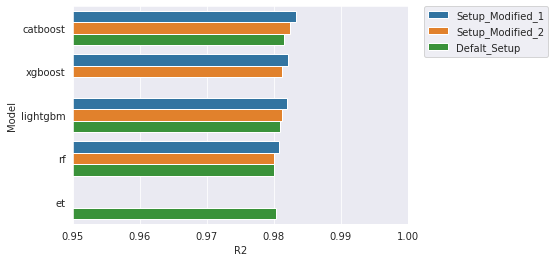

In [18]:
## 上位12の特徴量前処理、モデルを表示
sns.barplot(data=model_scores.sort_values('R2', ascending=False).iloc[0:12],
            x='R2', y='Model', hue='Desc')
plt.xlim(0.95,1.0)
plt.legend(bbox_to_anchor = (1.05, 1), # legendの原点をplot枠の外側に (x,y) 
           loc = 'upper left',         # 原点のlegend枠の位置 (左上)
           borderaxespad = 0)
plt.show()

## **モデルの選定 (automl)**


In [19]:
model = automl() # ベースモデル比較での最上位モデルを選択してモデル評価

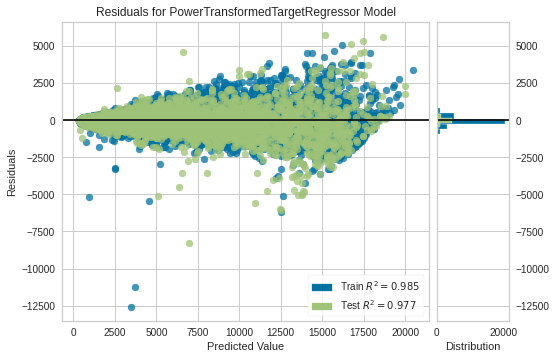

In [20]:
plot_model(model, plot='residuals') # 残差プロット

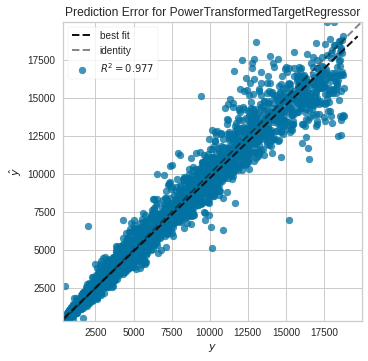

In [21]:
plot_model(model, plot='error') # 予測誤差(true-pred)プロット

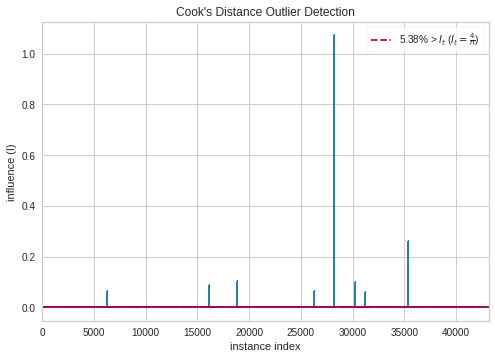

In [22]:
plot_model(model, plot='cooks') # クックの距離